<a href="https://colab.research.google.com/github/trinhqale/ECE188_Project2/blob/main/Adv_example_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing import image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [3]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [4]:
image_raw = tf.io.read_file('/content/chicken.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

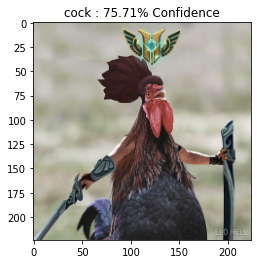

In [5]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [6]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

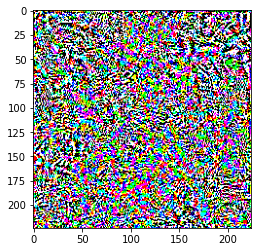

In [7]:
# Get the input label of the image.
giant_panda_index = 7
label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [8]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

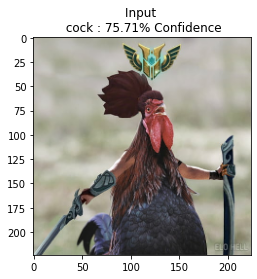

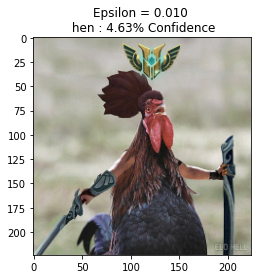

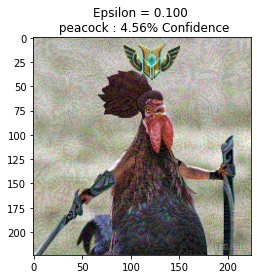

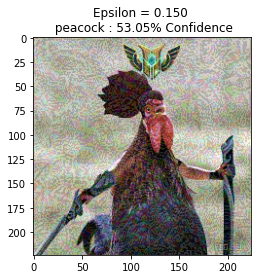

In [9]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

In [10]:
get_imagenet_label(pretrained_model.predict(image))

('n01514668', 'cock', 0.75709593)

In [11]:
correct_label = 'cock'
predicted_label = 'cock'
flag = 0
eps = 0.001
while(correct_label == predicted_label):
  adv_x = image + perturbations * (flag * eps)
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  _, predicted_label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))
  print(predicted_label)
  flag += 1
print(eps * flag)

cock
cock
cock
hen
0.004


# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [12]:
image_list_raw = [None] * 11
image_list_raw[0] = tf.io.read_file('/content/chicken.jpg')
image_list_raw[1] = tf.io.read_file('/content/Lion.jpg')
image_list_raw[2] = tf.io.read_file('/content/bear.jpg')
image_list_raw[3] = tf.io.read_file('/content/cat.jpg')
image_list_raw[4] = tf.io.read_file('/content/clownfish.jpg')
image_list_raw[5] = tf.io.read_file('/content/doggo.jpeg')
image_list_raw[6] = tf.io.read_file('/content/elephant.jpg')
image_list_raw[7] = tf.io.read_file('/content/koala.jpg')
image_list_raw[8] = tf.io.read_file('/content/panda.jpg')
image_list_raw[9] = tf.io.read_file('/content/shark.jpg')
image_list_raw[10] = tf.io.read_file('/content/tiger.jpg')

image_list = [None] * 11
image_probs_list = [None] * 11
for i in range(11):
  image_list[i] = tf.image.decode_image(image_list_raw[i])
  image_list[i] = preprocess(image_list[i])
  image_probs_list[i] = pretrained_model.predict(image_list[i])


In [13]:
animal_indexes = [7, 291, 294, 281, 393, 207, 386, 105, 388, 3, 292]
pertubations_list = []
for i in range(11):
  label = tf.one_hot(animal_indexes[i], image_probs_list[i].shape[-1])
  label = tf.reshape(label, (1, image_probs_list[i].shape[-1]))

  pertubations_list.append(create_adversarial_pattern(image_list[i], label))
  # plt.imshow(pertubations_list[i][0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [14]:

task2 = list()
correct_list = ['cock', 'lion', 'brown_bear', 'tabby', 'anemone_fish', 'golden_retriever', 'African_elephant', 'koala', 'giant_panda', 'tiger_shark', 'tiger']
predicted_list = ['cock', 'lion', 'brown_bear', 'tabby', 'anemone_fish', 'golden_retriever', 'African_elephant', 'koala', 'giant_panda', 'tiger_shark', 'tiger']

for i in range (11):
  flag = 0
  eps = 0.001
  while(correct_list[i] == predicted_list[i]):
    adv_x = image_list[i] + pertubations_list[i] * (flag * eps)
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, predicted_list[i], confidence = get_imagenet_label(pretrained_model.predict(adv_x))
    # print(predicted_list[i])
    flag += 1
  # print(f'{correct_list[i]}, {predicted_list[i]}')
  # print(eps * flag)
  task2.append((correct_list[i], predicted_list[i], eps*flag))



In [15]:
task2_df = pd.DataFrame(task2, columns=['correct label','predicted label', 'eps value'])
task2_df

,correct label,predicted label,eps value
0,cock,hen,0.004
1,lion,peacock,0.181
2,brown_bear,koala,0.015
3,tabby,Egyptian_cat,0.002
4,anemone_fish,rock_beauty,0.004
5,golden_retriever,Labrador_retriever,0.002
6,African_elephant,Indian_elephant,0.002
7,koala,Madagascar_cat,0.002
8,giant_panda,polecat,0.013
9,tiger_shark,great_white_shark,0.002


# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


In [16]:
#importing models
#model 1: MobileNet
mo_net = tf.keras.applications.MobileNet(include_top=True, weights='imagenet')
mo_net.trainable = False
# decode_predictions = tf.keras.applications.densenet.decode_predictions
# decode_predictions = tf.keras.applications.mobilenet.decode_predictions

In [19]:
def attack(pretrained_model, out):
  correct_list = ['cock', 'lion', 'brown_bear', 'tabby', 'anemone_fish', 'golden_retriever', 'African_elephant', 'koala', 'giant_panda', 'tiger_shark', 'tiger']
  predicted_list = ['cock', 'lion', 'brown_bear', 'tabby', 'anemone_fish', 'golden_retriever', 'African_elephant', 'koala', 'giant_panda', 'tiger_shark', 'tiger']

  for i in range (11):
    flag = 0
    eps = 0.001
    while(correct_list[i] == predicted_list[i]):
      adv_x = image_list[i] + pertubations_list[i] * (flag * eps)
      adv_x = tf.clip_by_value(adv_x, -1, 1)
      _, predicted_list[i], confidence = get_imagenet_label(pretrained_model.predict(adv_x))
      # print(predicted_list[i])
      flag += 1
    # print(f'{correct_list[i]}, {predicted_list[i]}')
    # print(eps * flag)
    out.append((correct_list[i], predicted_list[i], eps*flag))

In [20]:
mo_net_list = list()
attack(mo_net,  mo_net_list)
mo_net_df = pd.DataFrame(mo_net_list, columns=['correct label','predicted label', 'eps value'])

In [21]:
mo_net_df

,correct label,predicted label,eps value
0,cock,hoopskirt,0.091
1,lion,Persian_cat,0.196
2,brown_bear,ice_bear,0.155
3,tabby,Egyptian_cat,0.001
4,anemone_fish,rock_beauty,0.001
5,golden_retriever,Labrador_retriever,0.004
6,African_elephant,tusker,0.102
7,koala,Madagascar_cat,0.056
8,giant_panda,black-footed_ferret,0.320
9,tiger_shark,great_white_shark,0.001


In [23]:
dense_net = tf.keras.applications.DenseNet121(include_top=True, weights='imagenet')
dense_net.trainable = False

In [24]:
dense_net_list = list()
attack(dense_net, dense_net_list)
dense_net_df = pd.DataFrame(dense_net_list, columns=['correct label','predicted label', 'eps value'])
dense_net_df

,correct label,predicted label,eps value
0,cock,hen,0.015
1,lion,marmot,0.274
2,brown_bear,Kerry_blue_terrier,0.709
3,tabby,Egyptian_cat,0.001
4,anemone_fish,coral_reef,0.187
5,golden_retriever,Labrador_retriever,0.008
6,African_elephant,fur_coat,0.312
7,koala,Madagascar_cat,0.070
8,giant_panda,lesser_panda,0.370
9,tiger_shark,great_white_shark,0.001


In [27]:
denseNet169 = tf.keras.applications.DenseNet169(include_top=True, weights='imagenet')
denseNet169.trainable = False

In [29]:
dense_net_169_list = list()
attack(denseNet169, dense_net_169_list)
dense_net_169_df = pd.DataFrame(dense_net_169_list, columns=['correct label','predicted label', 'eps value'])
dense_net_169_df

,correct label,predicted label,eps value
0,cock,house_finch,0.065
1,lion,bloodhound,0.420
2,brown_bear,lesser_panda,0.524
3,tabby,lynx,0.001
4,anemone_fish,toyshop,0.172
5,golden_retriever,chow,0.001
6,African_elephant,tusker,0.253
7,koala,Madagascar_cat,0.102
8,giant_panda,brain_coral,0.609
9,tiger_shark,great_white_shark,0.001


In [30]:
denseNet201 = tf.keras.applications.DenseNet201(include_top=True,
                                                     weights='imagenet')
denseNet201.trainable = False

82534400/82524592 [==============================] - 3s 0us/step


In [31]:
denseNet201_list = list()
attack(denseNet201, denseNet201_list)
denseNet201_df = pd.DataFrame(denseNet201_list, columns=['correct label','predicted label', 'eps value'])
denseNet201_df

,correct label,predicted label,eps value
0,cock,hen,0.029
1,lion,lynx,0.302
2,brown_bear,Kerry_blue_terrier,0.561
3,tabby,Egyptian_cat,0.001
4,anemone_fish,shower_curtain,0.192
5,golden_retriever,Labrador_retriever,0.002
6,African_elephant,tusker,0.112
7,koala,Madagascar_cat,0.081
8,giant_panda,badger,0.621
9,tiger_shark,great_white_shark,0.001


In [32]:
NASNetMobile = tf.keras.applications.NASNetMobile(include_top=True,
                                                     weights='imagenet')
NASNetMobile.trainable = False

24240128/24227760 [==============================] - 0s 0us/step


In [33]:
NASNetMobile_list = list()
attack(NASNetMobile, NASNetMobile_list)
NASNetMobile_df = pd.DataFrame(NASNetMobile_list, columns=['correct label','predicted label', 'eps value'])
NASNetMobile_df

,correct label,predicted label,eps value
0,cock,hen,0.039
1,lion,Persian_cat,0.190
2,brown_bear,ice_bear,0.604
3,tabby,lynx,0.019
4,anemone_fish,brain_coral,0.431
5,golden_retriever,chow,0.001
6,African_elephant,tusker,0.001
7,koala,Madagascar_cat,0.056
8,giant_panda,meerkat,0.453
9,tiger_shark,great_white_shark,0.001


We've obtained the minimum epsilon to change the class of each image, along with 6 different models:

| Images\Models | MobileNetV2 | MobileNet |  DenseNet121|DenseNet169|DenseNet210|NASNetMobile
| ----------- | ----------- |  ----------- | --------| ---------| --------|-----
| cock      |   0.004     | 0.091  | 0.015|0.065|0.029|0.039
| lion       |  0.181       | 0.196 | 0.274|0.420|0.302|0.190
|brown_bear   |   0.015      | 0.155|0.709|0.524|0.561|0.604
| tabby   |  0.002       | 0.001|0.001|0.001|0.001|0.019
| anemone_fish   | 0.004        | 0.001 |0.187|0.172|0.192|0.431
| golden_retriever   |  0.002       | 0.004 |0.008|0.001|0.002|0.001
| African_elephant   |  0.002       | 0.102 |0.312|0.253|0.112|0.001
| koala   |  0.002       | 0.056 |0.07|0.102|0.081|0.056
| giant_panda   | 0.013        | 0.320 |0.37|0.609|0.621|0.453
| tiger_shark   |     0.002    | 0.001 |0.001|0.001|0.001|0.001
| tiger   |   0.003      | 0.084 |0.118|0.220|0.195|0.357

In [44]:
print(f'Average epsilon for each model: \n')
print("MobileNetV2: ", task2_df['eps value'].mean())
print("MobileNet: ", mo_net_df['eps value'].mean())
print("DenseNet121: ", dense_net_df['eps value'].mean())
print("DenseNet169: ", dense_net_169_df['eps value'].mean())
print("DenseNet210: ", denseNet201_df['eps value'].mean())
print("NASNetMobile: ", NASNetMobile_df['eps value'].mean())

Average epsilon for each model: 

MobileNetV2:  0.020909090909090912
MobileNet:  0.09190909090909093
DenseNet121:  0.18772727272727271
DenseNet169:  0.21527272727272723
DenseNet210:  0.19063636363636363
NASNetMobile:  0.1956363636363636


Conclusion: 
By observation, we can see that each MobileNet models are easier to break compared to DenseNet and NASNetMobile.

1. The expected result of robustness should be:


    DenseNet201-> DenseNet169 -> DenseNet121 -> NASNetMobile -> MobileNetV2 -> MobileNet (based on the description of each model)


2. However, our result (average of each model) does not reflect that expected result. The reason for this is because the images we chose were hard to predict so that it's easy to confuse the models. The dataset has a lot of outliers that might ruin the actual result. 

# BONUS: Can you provide a better attack? No thank you I'm good :P

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 